In [15]:
#import warnings
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
#warnings.filterwarnings('ignore')

**Question #1**

a. Implement an Erdős–Rényi model. Write a function that gets n - number of
nodes and p - probability of an edge and returns a random graph.

In [16]:
def erdos_renyi_model(n, p):
  G=nx.Graph()
  G.add_nodes_from(range(n))
  for n1 in G.nodes():
    for n2 in G.nodes():
      if n1 > n2 and random.uniform(0, 1) <= p:
        G.add_edge(n1, n2)
  return G

b. Implement a function that computes the clustering coefficient of a given graph.
Implement a helper function that computes clustering coefficient of each node.

In [17]:
def clustering_coefficient_of_graph(G):
  sum_clustering_coefficient = 0
  for n in G.nodes():
    sum_clustering_coefficient += clustering_coefficient_of_node(G, n)
  clustering_coefficient = sum_clustering_coefficient / G.number_of_nodes()
  return clustering_coefficient

def clustering_coefficient_of_node(G, n):
  sum_of_neighbors_edges = 0
  for neighbor1 in nx.all_neighbors(G, n):
    for neighbor2 in nx.all_neighbors(G, n):
      if neighbor1 > neighbor2 and G.has_edge(neighbor1, neighbor2):
        sum_of_neighbors_edges += 1
  number_of_neighbors = G.degree(n)
  if number_of_neighbors <= 1:
    clustering_coefficient = 0
  else:
    clustering_coefficient = 2*sum_of_neighbors_edges / (number_of_neighbors*(number_of_neighbors - 1))
  return clustering_coefficient

**Question #2**

a. Implement 3 centrality measures: Degree centrality, Betweenness centrality
and Closeness centrality.

In [18]:
def degree_centrality_of_node(G, node):
  n = G.number_of_nodes()
  degree_centrality = (1 / (n - 1)) * G.degree(node)
  return degree_centrality


def betweenness_centrality_of_node(G, node):
  betweenness_centrality = 0
  n = G.number_of_nodes()
  for n1 in G.nodes():
    for n2 in G.nodes():
      if n1 != node and n2 != node and n1 > n2:
        sum_shortest_path_include_node = 0
        all_shortest_paths = list(nx.all_shortest_paths(G, n1, n2))
        for path in all_shortest_paths:
          if node in path:
            sum_shortest_path_include_node += 1
        sum_shortest_paths = len(all_shortest_paths)
        betweenness_centrality += sum_shortest_path_include_node / sum_shortest_paths
  betweenness_centrality = (2 / ((n - 1)*(n - 2))) * betweenness_centrality
  return betweenness_centrality


def closeness_centrality_of_node(G, node):
  sum_shortest_path_length = 0
  for n in G.nodes():
    if n != node:
      sum_shortest_path_length += nx.shortest_path_length(G, source=node, target=n)
  closeness_centrality = (G.number_of_nodes() - 1) * (1 / sum_shortest_path_length)
  return closeness_centrality
       

b. Run these measures on a random Gnp network with n=15 and p=0.5 and
report top-5 nodes according to each of the measures.


In [19]:
G = erdos_renyi_model(n=15, p=0.5)
#top-5 nodes according to degree centrality measures.
degree_centralities = np.array([degree_centrality_of_node(G, n) for n in G.nodes()])
top_5_degree_centralities = np.flip(np.argpartition(degree_centralities, -5)[-5:])
print("The top-5 nodes according to degree centrality measures are: ", np.array_str(top_5_degree_centralities))
#top-5 nodes according to betweenness centrality measures.
betweenness_centralities = [betweenness_centrality_of_node(G, n) for n in G.nodes()]
top_5_betweenness_centralities = np.flip(np.argpartition(betweenness_centralities, -5)[-5:])
print("The top-5 nodes according to betweenness centrality measures are: ", np.array_str(top_5_betweenness_centralities))
#top-5 nodes according to closeness centrality measures.
closeness_centralities = [closeness_centrality_of_node(G, n) for n in G.nodes()]
top_5_closeness_centralities = np.flip(np.argpartition(closeness_centralities, -5)[-5:])
print("The top-5 nodes according to closeness centrality measures are: ", np.array_str(top_5_closeness_centralities))


The top-5 nodes according to degree centrality measures are:  [ 3 10 12  6 11]
The top-5 nodes according to betweenness centrality measures are:  [ 3 10 12 11  1]
The top-5 nodes according to closeness centrality measures are:  [ 3 10 12  6 11]


c. Visualize the network using different centrality measures by changing node
sizes based on the centrality measure value of each node.


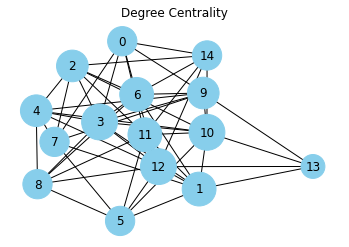

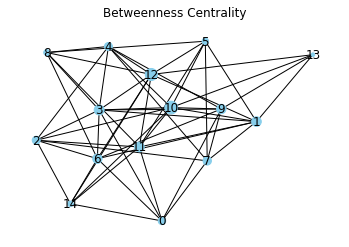

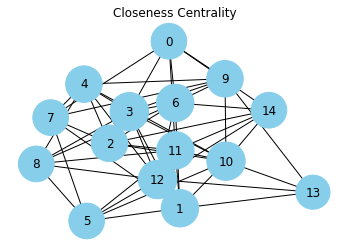

In [20]:
plt.figure(1)
plt.title("Degree Centrality")
nx.draw(G, with_labels=True, node_color="skyblue", node_size=[v*2000 for v in degree_centralities])
plt.figure(2)
plt.title("Betweenness Centrality")
nx.draw(G, with_labels=True, node_color="skyblue", node_size=[v*2000 for v in betweenness_centralities])
plt.figure(3)
plt.title("Closeness Centrality")
nx.draw(G, with_labels=True, node_color="skyblue", node_size=[v*2000 for v in closeness_centralities])
plt.show()

**Question #3**

a. Implement check_balance(G) function that checks balance (according to
“Theory of Structural Balance”) of a G. Explain your implementation decision.

In [21]:
def check_balance(G):
  #Build +edges Graph
  G_plus_edges = nx.Graph()
  G_plus_edges.add_nodes_from(G.nodes())
  for (u, v, edge_data) in G.edges(data=True):
    if edge_data['label'] == '+':
      G_plus_edges.add_edge(u, v)
  #Check if a component of nodes on +edges contains a –edge
  connected_components = []
  for connected_component in nx.connected_components(G_plus_edges):
    connected_components.append(list(connected_component))
  for super_node in connected_components:
    for node1 in super_node:
      for node2 in super_node:
        if node1 > node2 and G.has_edge(node1, node2) and G.get_edge_data(node1, node2)['label'] == '-':
          return False
  #Build connected component graph
  connected_components_graph = nx.Graph()
  node_to_connected_component = [None]*G.number_of_nodes()
  #For each component create a super node
  for index in range(len(connected_components)):
    connected_components_graph.add_node(index)
    for node in connected_components[index]:
      node_to_connected_component[node] = index
  #Connect components if there is a negative edge between the members
  for (u, v, edge_data) in G.edges(data=True):
    connected_component_of_u = node_to_connected_component[u]
    connected_component_of_v = node_to_connected_component[v]
    if edge_data['label'] == '-' and connected_component_of_u != connected_component_of_v:
      connected_components_graph.add_edge(u, v)
  return nx.is_bipartite(connected_components_graph)

b. Generate a random network using Erdős–Rényi using n=10 and p=0.4. On
each edge, assign random sign (“+” or “-”) with different probabilities:


i. p(+) = 0.95, p(-) = 0.05

ii. p(+) = 0.05, p(-) = 0.95

In [22]:
def label_edges_with_probability(G, p):
  labeled_G = nx.Graph()
  labeled_G.add_nodes_from(G.nodes())
  for edge in G.edges():
    if random.uniform(0, 1) <= p:
      labeled_G.add_edge(*edge, label='+')
    else:
      labeled_G.add_edge(*edge, label='-')
  return labeled_G

G = erdos_renyi_model(n=10, p=0.4)
Gi = label_edges_with_probability(G, p=0.95)
Gii = label_edges_with_probability(G, p=0.05)

c. Visualize the graph with different colors for positive and negative edges. Run
the check_balance(G) on each of the graphs.


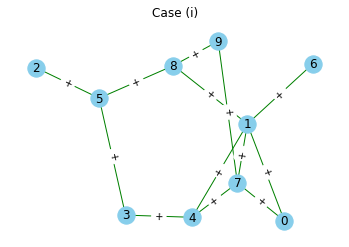

Gi is balance


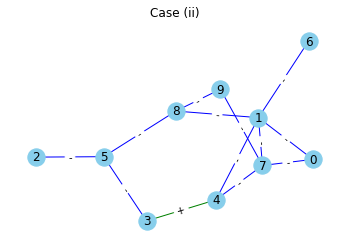

Gii is unbalance


In [23]:
def draw_graph_with_color_by_label(G):
  pos = nx.spring_layout(G)
  plus_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d['label'] =='+']
  minus_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d['label'] =='-']
  nx.draw_networkx_nodes(G, pos, node_color='skyblue')
  nx.draw_networkx_edges(G, pos, edgelist=plus_edges, edge_color='green')
  nx.draw_networkx_edges(G, pos, edgelist=minus_edges, edge_color='blue')
  nx.draw_networkx_labels(G, pos)
  edge_labels =dict([((u, v), d['label']) for u, v, d in G.edges(data=True)])
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
  plt.axis('off')
  plt.show()

plt.figure(1)
plt.title("Case (i)")
draw_graph_with_color_by_label(Gi)
print("Gi is balance") if check_balance(Gi) else print("Gi is unbalance")
plt.figure(2)
plt.title("Case (ii)")
draw_graph_with_color_by_label(Gii)
print("Gii is balance") if check_balance(Gii) else print("Gii is unbalance")